# Panteleeva Svetlana

## 1. Data preparation 

In [175]:
import pandas as pd
import numpy as np

### Dataset 1 : Tic-Tac-Toe
https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame

In [565]:
df_1 = pd.read_csv('tic-tac-toe.csv', sep=',')
df_1.rename(columns={'V10': 'Y'}, inplace=True)
df_1 = df_1.replace(to_replace='positive', value=1)
df_1 = df_1.replace(to_replace='negative', value=0)
df_dummy_1 = pd.get_dummies(df_1)

### Dataset 2 : Bank Marketing
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [566]:
data = pd.read_csv('bank-additional.csv', sep=';')
#Переименование целевой метки в "Y"
data.rename(columns={'y': 'Y'}, inplace=True)
#Удаление missing value
data = data[data['job'] != 'unknown']
data = data[data['marital'] != 'unknown']
data = data[data['education'] != 'unknown']
data = data[data['default'] != 'unknown']
data = data[data['housing'] != 'unknown']
data = data[data['duration'] != 0]
#Преобразование числовых данных в категориальные
data['Age_c'] = pd.qcut(data['age'], 3)
data['ec1'] = pd.qcut(data['emp.var.rate'], 2)
data['ec2'] = pd.qcut(data['cons.price.idx'], 3)
data['ec3'] = pd.qcut(data['cons.conf.idx'], 3)
data['ec4'] = pd.qcut(data['euribor3m'], 3)
data['ec5'] = pd.qcut(data['nr.employed'], 2)
data['c'] = pd.qcut(data['campaign'], 2)
data['d'] = pd.qcut(data['duration'], 4)
df_2 = data.drop(['age','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','campaign','duration'],axis = 1)
#Преобразование категориальных в бинарные
df_2 = df_2.replace(to_replace='yes', value=1)
df_2 = df_2.replace(to_replace='no', value=0)
df_2.loc[df_2['pdays'] != 999,'pdays'] = 1
df_2.loc[df_2['pdays'] == 999,'pdays'] = 0
df_2.loc[df_2['previous'] != 0,'previous'] = 1
df_2.loc[df_2['previous'] == 0,'previous'] = 0
df_dummy_2 = pd.get_dummies(df_2)

### Dataset 3: Early stage diabetes risk prediction dataset
https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.

In [567]:
df_2 = pd.read_csv('diabetes_data_upload.csv', sep=',')
#Переименование целевой метки в "Y"
df_2.rename(columns={'class': 'Y'}, inplace=True)
#Преобразование числовых данных в категориальные
df_2['Age'] = pd.qcut(df_2['Age'], 4)
#Преобразование категориальных в бинарные
df_2 = df_2.replace(to_replace='Yes', value=1)
df_2 = df_2.replace(to_replace='No', value=0)
df_2 = df_2.replace(to_replace='Positive', value=1)
df_2 = df_2.replace(to_replace='Negative', value=0)
df_2 = df_2.replace(to_replace='Male', value=1)
df_2 = df_2.replace(to_replace='Female', value=0)
df_dummy_2 = pd.get_dummies(df_2)

### Cross Validation
Makes cross validation of prepared dataset in N splits and saves to selected path. 

In [385]:
from sklearn import model_selection
import sys

def cross_validation(path_in, path_out, n_splits):
    
    df_prep = path_in
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=None)
    kf.get_n_splits(df_prep)
    k = 1
    
    for train_index, test_index in kf.split(df_prep):
        df_prep.iloc[train_index].to_csv('_train_'+str(k)+'.csv',index=False)
        df_prep.iloc[test_index].to_csv('_test_'+str(k)+'.csv',index=False)
        k += 1
        
    return 'Cross Validation Completed'

In [510]:
# path_out = './'
# cross_validation(path_in=df_dummy_2,
#                  path_out = path_out,
#                  n_splits=6)

'Cross Validation Completed'

### Separate X from Y. Create plus_context and minus_context. Make a required format. 

In [180]:
def data_preprocessing(path_train, path_test):
    train = pd.read_csv(path_train)
    test = pd.read_csv(path_test)
    
    X_train = train.drop(['Y'], axis=1).to_numpy()
    y_train = train['Y'].to_numpy()
    X_test = test.drop(['Y'], axis=1).to_numpy()
    y_test = test['Y'].to_numpy()
        
    X_train_pos = X_train[y_train == 1] #plus_context
    X_train_neg = X_train[y_train == 0] #minus_context
#         print(X_train_pos, X_train_neg)

    return X_train_pos, X_train_neg, X_train, y_train, X_test, y_test

In [498]:
#Функция которая из массивов делает set{} из строк, каждой строкой является: 'название колонки:элемент(1 или 0)'  
def make_set(example, dataset):
    if dataset == 1:
        attrib_names = list(pd.get_dummies(df_1.drop(['Y'], axis=1)))
    if dataset == 2:
        attrib_names = list(pd.get_dummies(df_2.drop(['Y'], axis=1)))     
    return set([i+':'+str(k) for i, k in zip(attrib_names,example)])

# 2. Algorithms

### Algorithm 1 
Алгоритм на основе системы голосования. Пример из плюс контекста голосует за положительную классификацию, если пересечение его описания с описаниями классифицируемых объектов, вкладывается не более, чем определенное кол-во раз (threshold_subset) в описание объектов из минус-контекста. (= Длина списка, составленная из тех описаний объектов из минус-контекста, подмножествами которых являются пересечения описаний плюс-контекста и тестового, не больше определенного числа). И наоборот.   

Algorithm based on the voting system. Every plus context objects votes for a positive classification if the intersection of its description with the descriptions of classified objects is nested no more than a certain threshold number of times (threshold_subset) in the description of minus context objects. 
(= The length of the list, composed of such descriptions of minus-context objects, the subsets of which are the intersections of the descriptions of the plus-context and the test object, is not more than a certain number). And vice versa.

Test object classifies positive, if there is more votes for plus classification (and vice versa).

In [482]:
def alg_1(x_test, x_train_pos, x_train_neg, dataset, threshold_subset):
    
    y_pred = []
    clas = 0
    random_counter = 0
    for el in x_test:
        eintent = make_set(el, dataset)
        labels = {"positive": 0, "negative": 0}
        for e in x_train_pos:
            ei = make_set(e, dataset)
            candidate_intent = ei & eintent
            closure = [make_set(i, dataset) for i in x_train_neg if make_set(i, dataset).issuperset(candidate_intent)]
            #closure -  это список из объектов минус контекта (только тех в которые входит пересечение)
            if len(closure) <= threshold_subset:
                labels["positive"] += 1
            
        for e in x_train_neg:
            ei = make_set(e, dataset)
            candidate_intent = ei & eintent
            closure = [make_set(i, dataset) for i in x_train_pos if make_set(i, dataset).issuperset(candidate_intent)]
            if len(closure) <= threshold_subset:
                labels["negative"] += 1

        labels["positive"] = float(labels["positive"]) / len(x_train_pos)
        labels["negative"] = float(labels["negative"]) / len(x_train_neg)

        if labels["positive"] == labels["negative"]:
#             clas = random.choice([0,1])
            clas = int(str(datetime.now())[17:19])
            clas %= 2
            random_counter += 1
        if labels["positive"] > labels["negative"]:
            clas = 1
        if labels["negative"] > labels["positive"]:
            clas = 0
        y_pred.append(clas)
        random_norm = random_counter/len(x_test)
    
    return y_pred, random_norm

### Algorithm 2 
Algorithm classifies test object by maximum subset of intersection of descriptions of plus context object and test object in descriptions of minus context object. And vice versa.
It has threshold_intersec, which controls, how many elements can be in plus/minus context and test sets intersection.

Алгоритм классифицирует тестовый объект положительно по максимальному подмножеству пересечения описания плюс контекста и тестового объекта в описании минус контекста. Eсли относительный размер пересечения описания объекта из плюсового контекста с описанием тестового объектом (пороговое число в процентах от тестового) больше определенного числа threshold_intersec.

Test object classifies positive, if there is more votes for plus classification (and vice versa).

In [501]:
def alg_2(x_test, x_train_pos, x_train_neg, dataset, threshold_intersec):
    
    norm_plus = (len(x_train_pos)+len(x_train_neg))//len(x_train_pos)
    norm_minus = (len(x_train_neg)+len(x_train_neg))//len(x_train_neg)
    y_pred = []
    random_counter = 0
    
    for el in x_test:
        x_test_set = make_set(el, dataset)
        max_subset_pos = 0
        max_subset_neg = 0
        for e in x_train_pos:
            counter_plus = 0 
            ei = make_set(e, dataset)
            candidate_intent = ei & x_test_set
            intersec_plus_len_norm = len(candidate_intent)/len(x_test_set)
            if intersec_plus_len_norm < threshold_intersec:
                continue  
            closure = [make_set(i, dataset) for i in x_train_neg if make_set(i, dataset).issuperset(candidate_intent)]                      
            if closure:
                counter_plus +=1 
                max_subset_pos = max(counter_plus, max_subset_pos) 
       
        for e in x_train_neg:
            counter_minus = 0 
            ei = make_set(e, dataset)
            candidate_intent = ei & x_test_set
            intersec_plus_len_norm = len(candidate_intent)/len(x_test_set)
            if intersec_plus_len_norm < threshold_intersec:
                continue
            closure = [make_set(i, dataset) for i in x_train_pos if make_set(i, dataset).issuperset(candidate_intent)]
            if closure:
                counter_minus +=1
                max_subset_neg = max(counter_minus,max_subset_neg)

        if max_subset_pos<max_subset_neg:
            y_pred.append(0)
        if max_subset_pos>max_subset_neg:
            y_pred.append(1)
        if max_subset_pos==max_subset_neg:
            random_counter += 1
            A = int(str(datetime.now())[17:19])
            A %= 2
            y_pred.append(A)
#         y_pred.append(max_subset_pos<max_subset_neg)
#         y_pred_=np.where(y_pred,1,0)
           
    random_norm = 1 - random_counter/len(x_test)
    
    return y_pred, random_norm

# 3. Metrics evaluation

In [190]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [217]:
def metrics_test(y_test, y_pred):
    
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    TP = np.sum(y_test * y_pred)
    TN = np.sum(y_test + y_pred == 0)
    FP = np.sum((y_test  == 0) * (y_pred == 1))
    FN = np.sum((y_test  == 1) * (y_pred == 0))
    TPR = float(TP) / np.sum(y_test == 1)
    TNR = float(TN) / np.sum(y_test == 0)
    FPR = float(FP) / (TP + FN)
    NPV = float(TN) / (TN + FN)
    FDR = float(FP) / (TP + FP)
    acc = accuracy_score(y_test, y_pred) #(TP + TN) / (TP + TN + FP + FN)
    prec = precision_score(y_test, y_pred) #= TP / (TP + FP)
    rec = recall_score(y_test, y_pred) #= TP / (TP + FN)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    return TP, TN, FP, FN, TPR, TNR, FPR, NPV, FDR, acc, prec, rec, roc_auc

In [218]:
def print_metrics(metrics):
    
    print('True Positive: {:.4f}'.format(metrics[0]))
    print('True Negative: {:.4f}'.format(metrics[1]))
    print('False Positive: {:.4f}'.format(metrics[2]))
    print('False Negativee: {:.4f}'.format(metrics[3]))
    print('True Positive Rate: {:.4f}'.format(metrics[4]))
    print('True Negative Rate: {:.4f}'.format(metrics[5]))
    print('False Positive Rate: {:.4f}'.format(metrics[6]))
    print('Negative Predictive Value: {:.4f}'.format(metrics[7]))
    print('False Discovery Rate: {:.4f}'.format(metrics[8]))
    print('Accuracy score: {:.4f}'.format(metrics[9]))
    print('Precision Score: {:.4f}'.format(metrics[10]))
    print('Recall Score: {:.4f}'.format(metrics[11]))
    print('Roc AUC Score: {:.4f}'.format(metrics[12]))

# 4. Launching and evaluating algorithms

In [502]:
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
from datetime import datetime

def main(alg_n, n_splits, dataset, threshold_subset=0, threshold_intersec=0.7):
    
    # time on
    import timeit
    start = timeit.default_timer()
    
    # 1. step - Cross Validation
    path_out = './'     
    cross_validation(path_in=pd.get_dummies(df_1 if dataset == 1 else df_2),#df_bool
                        path_out = path_out,
                        n_splits=n_splits)    

    metrics = []
    # 2. step - Data Preprocessing
    for i in tq(range(1,n_splits+1)):
        path_train = r'_train_'+str(i)+r'.csv' 
        path_test = r'_test_'+str(i)+r'.csv'
        X_train_pos, X_train_neg, X_train, y_train, X_test, y_test = data_preprocessing(path_train,
                                                                                        path_test)
        # 3. step - Launching algorithms
        if alg_n == 1:
            y_pred, randoms = alg_1(X_test, X_train_pos, X_train_neg, dataset, threshold_subset=0 )
            
        if alg_n == 2:
            y_pred, randoms = alg_2(X_test, X_train_pos, X_train_neg, dataset, threshold_intersec=0 )
    
        if alg_n == 'bernoulliNB':
            from sklearn.preprocessing import LabelBinarizer
#             from sklearn.naive_bayes import BernoulliNB
            clf = BernoulliNB()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            randoms = 0
        
        # 4. step - Evaluating algorithms
        metrics_ = []
        TP, TN, FP, FN, TPR, TNR, FPR, NPV, FDR, acc, prec, rec, roc_auc = metrics_test(y_test=y_test, y_pred=y_pred)
        for metric in [TP, TN, FP, FN, TPR, TNR, FPR, NPV, FDR, acc, prec, rec, roc_auc]:
            metrics_.append(metric)
        metrics.append(metrics_)

    avg_metrics = np.mean(np.array(metrics), axis=0)
    
    # time off    
    stop = timeit.default_timer()
    time = stop - start
    print ('Algorithm runtime: {}'.format(time))
    return avg_metrics, randoms

# 5. Find optimal parameters

## Tic-Tac-Toe Dataset
### Algorithm 1


Algorithm runtime: 162.9939171000151



Algorithm runtime: 109.51542420001351



Algorithm runtime: 109.356288400013



Algorithm runtime: 106.16987700000755



Algorithm runtime: 136.51104120002128



Algorithm runtime: 119.78029779999633



Algorithm runtime: 107.05741919999127



Algorithm runtime: 105.98633300000802



Algorithm runtime: 113.41376689999015


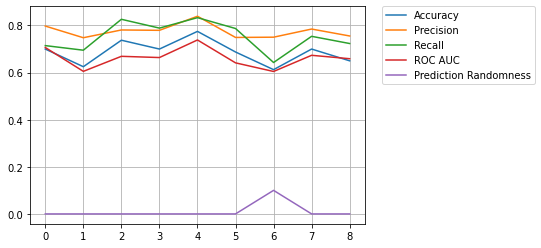

In [205]:
avg_m_arr = np.empty((0,5), float)
for i in range(0,27,3):
    metrics, rand = main(alg_n=1, n_splits = 4, dataset = 1, threshold_subset = i)
    metr = np.array([metrics[9],metrics[10],metrics[11],metrics[12],rand])
    avg_m_arr = np.vstack([avg_m_arr, metr])
    
plt.plot(avg_m_arr)
plt.legend(['Accuracy', 'Precision','Recall', 'ROC AUC','Prediction Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()  

### Algorithm 2


Algorithm runtime: 138.96202110001468



Algorithm runtime: 135.24014700000407



Algorithm runtime: 146.68255719999433



Algorithm runtime: 136.0719112000079



Algorithm runtime: 129.6682937000005



Algorithm runtime: 137.75421859999187



Algorithm runtime: 141.60716580000008



Algorithm runtime: 143.6241558000038



Algorithm runtime: 133.91451420000521


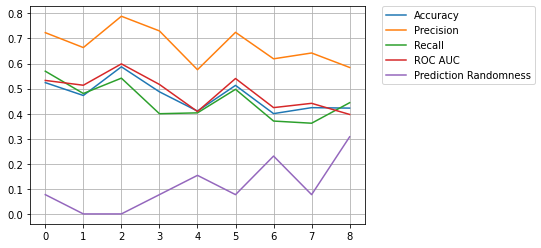

In [364]:
avg_m_arr = np.empty((0,5), float)
for i in range(0,9):
    metrics, rand = main(alg_n=2, n_splits = 6, dataset = 1, threshold_intersec = (i/10))
    metr = np.array([metrics[9],metrics[10],metrics[11],metrics[12],rand])
    avg_m_arr = np.vstack([avg_m_arr, metr])
    
plt.plot(avg_m_arr)
plt.legend(['Accuracy', 'Precision','Recall', 'ROC AUC','Prediction Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show() 

## Dataset Bank
### Algorithm 1


Algorithm runtime: 0.6333805000176653



Algorithm runtime: 0.8110047000227496



Algorithm runtime: 0.418705600022804



Algorithm runtime: 0.4480396000435576



Algorithm runtime: 0.7679018000490032



Algorithm runtime: 2.318725099961739



Algorithm runtime: 0.394281700020656



Algorithm runtime: 0.5028602000093088



Algorithm runtime: 14.947181799972896



Algorithm runtime: 0.40855930000543594



Algorithm runtime: 0.38563749997410923



Algorithm runtime: 0.6325211999937892



Algorithm runtime: 0.39706920000026



Algorithm runtime: 0.6793498000479303



Algorithm runtime: 0.6475252999807708


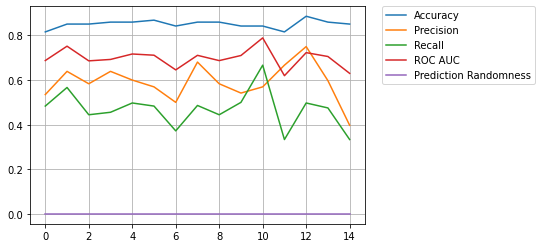

In [515]:
#Bank new
avg_m_arr = np.empty((0,5), float)
for i in range(0,75,5):
    metrics, rand = main(alg_n=1, n_splits = 6, dataset = 2, threshold_subset = i)
    metr = np.array([metrics[9],metrics[10],metrics[11],metrics[12],rand])
    avg_m_arr = np.vstack([avg_m_arr, metr])
    
plt.plot(avg_m_arr)
plt.legend(['Accuracy', 'Precision','Recall', 'ROC AUC','Prediction Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.grid()
plt.show() 

### Algorithm 2


Algorithm runtime: 0.5638211999903433



Algorithm runtime: 0.6864892999874428



Algorithm runtime: 0.9837200000183657



Algorithm runtime: 0.45735889999195933



Algorithm runtime: 0.5576883999747224



Algorithm runtime: 0.5140526000177488



Algorithm runtime: 0.5655129999504425



Algorithm runtime: 0.5633235999848694



Algorithm runtime: 0.6492728000157513



Algorithm runtime: 0.39768569997977465



Algorithm runtime: 0.565629800024908


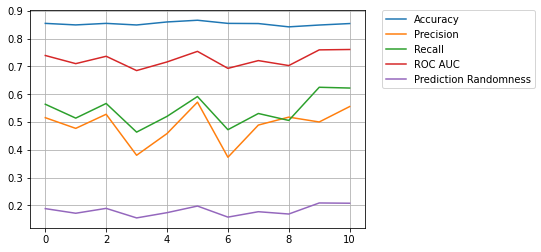

In [562]:
avg_m_arr = np.empty((0,5), float)
for i in range(0,11):
    metrics, rand = main(alg_n=2, n_splits = 6, dataset = 1, threshold_intersec = (i/10))
    metr = np.array([metrics[9],metrics[10],metrics[11],metrics[12],rand])
    avg_m_arr = np.vstack([avg_m_arr, metr])
    
plt.plot(avg_m_arr)
plt.legend(['Accuracy', 'Precision','Recall', 'ROC AUC','Prediction Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show() 

## Dataset Diabetes
### Algorithm 1


Algorithm runtime: 241.52838709997013



Algorithm runtime: 196.41934969997965



Algorithm runtime: 214.61990579997655



Algorithm runtime: 208.37761329999194



Algorithm runtime: 228.22957089997362



Algorithm runtime: 206.5150818999973



Algorithm runtime: 195.83359930000734



Algorithm runtime: 180.95574389997637



Algorithm runtime: 195.30868010001723



Algorithm runtime: 186.9844666000572



Algorithm runtime: 205.12930939998478


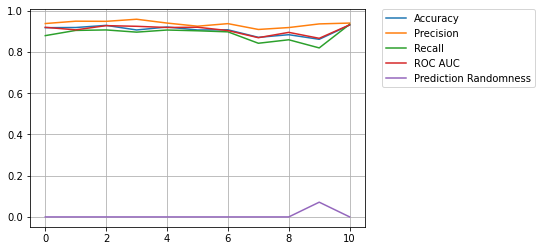

In [464]:
avg_m_arr = np.empty((0,5), float)
for i in range(0,22,2):
    metrics, rand = main(alg_n=1, n_splits = 6, dataset = 2, threshold_subset = i)
    metr = np.array([metrics[9],metrics[10],metrics[11],metrics[12],rand])
    avg_m_arr = np.vstack([avg_m_arr, metr])
    
plt.plot(avg_m_arr)
plt.legend(['Accuracy', 'Precision','Recall', 'ROC AUC','Prediction Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show() 

### Algoritm 2


Algorithm runtime: 205.9950953000225



Algorithm runtime: 206.33850889996393



Algorithm runtime: 212.7298209000146



Algorithm runtime: 205.5710468000034



Algorithm runtime: 225.18483990000095



Algorithm runtime: 209.02532330004033



Algorithm runtime: 201.69912450003903



Algorithm runtime: 210.90589290001662



Algorithm runtime: 197.68005630001426



Algorithm runtime: 204.12658589996863



Algorithm runtime: 209.62773639999796


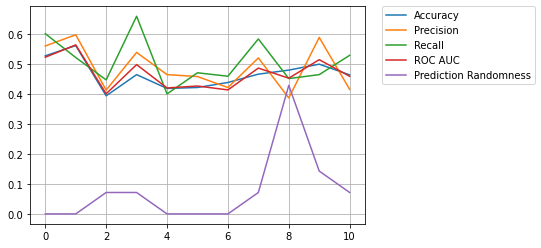

In [466]:
avg_m_arr = np.empty((0,5), float)
for i in range(0,11):
    metrics, rand = main(alg_n=2, n_splits = 6, dataset = 2, threshold_intersec = i/10)
    metr = np.array([metrics[9],metrics[10],metrics[11],metrics[12],rand])
    avg_m_arr = np.vstack([avg_m_arr, metr])
    
plt.plot(avg_m_arr)
plt.legend(['Accuracy', 'Precision','Recall', 'ROC AUC','Prediction Randomness'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show() 

## Hyperparameters results:
Best hyperparameter for first algorithm
 - for Tic-tac-toe dataset on iteration number 4 is threshold_subset = 9  
 - for dataset Bank on iteration number 9 is threshold_subset = 45
 - for diabetes dataset on iteration number 1-4 is threshold_subset = 2-8
 
Best hyperparameter for second algorithm is threshold_intersec = 0.2, 0.8, and 0,1 for three datasets respectfully.

# 7. Print metrics with bets hyperparameters:

In [91]:
# Dataset Tic-Tac-Toe, Algoritm 1,threshold_subset = 9
metrics, randoms = main(alg_n=1, n_splits = 6, dataset = 1, threshold_subset=9)
print_metrics(metrics)


Algorithm runtime: 206.08376500000304
True Positive: 9.8333
True Negative: 2.3333
False Positive: 2.6667
False Negativee: 1.1667
True Positive Rate: 0.9018
True Negative Rate: 0.5258
False Positive Rate: 0.2840
Negative Predictive Value: 0.7444
False Discovery Rate: 0.2096
Accuracy score: 0.7604
Precision Score: 0.7904
Recall Score: 0.9018
Roc AUC Score: 0.7138


In [494]:
# Dataset Tic-Tac-Toe, Algoritm 2,threshold_intersec = 0.2
metrics, randoms = main(alg_n=2, n_splits = 6, dataset = 1, threshold_intersec = 0.2)
print_metrics(metrics)
print(randoms)


Algorithm runtime: 233.53013920004014
True Positive: 5.3333
True Negative: 3.1667
False Positive: 1.8333
False Negativee: 5.6667
True Positive Rate: 0.4678
True Negative Rate: 0.6345
False Positive Rate: 0.1708
Negative Predictive Value: 0.3423
False Discovery Rate: 0.2839
Accuracy score: 0.5312
Precision Score: 0.7161
Recall Score: 0.4678
Roc AUC Score: 0.5511
0.0625


In [534]:
# Dataset Bank, Algoritm 1, ,threshold_subset = 45
metrics, randoms = main(alg_n=1, n_splits = 6, dataset = 2, threshold_subset = 45)
print_metrics(metrics)


Algorithm runtime: 1.0373162999749184
True Positive: 1.2000
True Negative: 13.6000
False Positive: 1.2000
False Negativee: 1.2000
True Positive Rate: 0.3967
True Negative Rate: 0.9197
False Positive Rate: 0.8033
Negative Predictive Value: 0.9185
False Discovery Rate: 0.5200
Accuracy score: 0.8601
Precision Score: 0.4800
Recall Score: 0.3967
Roc AUC Score: 0.6582


In [563]:
# Dataset Bank, Algoritm 2, threshold_intersec = 0,8
metrics, randoms= main(alg_n=2, n_splits = 6, dataset = 1, threshold_intersec = 0.8)
print_metrics(metrics)


Algorithm runtime: 1.0117330999928527
True Positive: 1.4000
True Negative: 13.3000
False Positive: 1.5000
False Negativee: 1.0000
True Positive Rate: 0.5967
True Negative Rate: 0.8983
False Positive Rate: 1.0567
Negative Predictive Value: 0.9332
False Discovery Rate: nan
Accuracy score: 0.8542
Precision Score: 0.4217
Recall Score: 0.5967
Roc AUC Score: 0.7475


In [503]:
# Dataset Diabetes, Algoritm 1, ,threshold_subset = 2
metrics, randoms = main(alg_n=1, n_splits = 6, dataset = 2, threshold_subset=2)
print_metrics(metrics)
print('Randomness of prediction:', randoms)


Algorithm runtime: 1084.3606970999972
True Positive: 6.6667
True Negative: 6.5000
False Positive: 0.3333
False Negativee: 0.8333
True Positive Rate: 0.8854
True Negative Rate: 0.9583
False Positive Rate: 0.0516
Negative Predictive Value: 0.8810
False Discovery Rate: 0.0571
Accuracy score: 0.9183
Precision Score: 0.9429
Recall Score: 0.8854
Roc AUC Score: 0.9219
Randomness of prediction: 0.0


In [542]:
# Dataset Diabetes, Algoritm 2, threshold_intersec = 0.1
metrics, randoms = main(alg_n=2, n_splits = 6, dataset = 1, threshold_subset=0.1)
print_metrics(metrics)
print('Randomness of prediction:', randoms)


Algorithm runtime: 1240.036136300012
True Positive: 4.5000
True Negative: 2.5000
False Positive: 2.5000
False Negativee: 6.5000
True Positive Rate: 0.4085
True Negative Rate: 0.5000
False Positive Rate: 0.2424
Negative Predictive Value: 0.2750
False Discovery Rate: 0.3498
Accuracy score: 0.4375
Precision Score: 0.6502
Recall Score: 0.4085
Roc AUC Score: 0.4542
Randomness of prediction: 0.0625


# 8. Compare with Bernoulli Naive Bayes Algorithm
 

In [540]:
# Dataset Tic-Tac-Toe
metrics, randoms = main(alg_n='bernoulliNB', n_splits = 10, dataset = 1)
print_metrics(metrics)


Algorithm runtime: 0.55052109999815
True Positive: 5.3000
True Negative: 1.4000
False Positive: 1.6000
False Negativee: 1.3000
True Positive Rate: 0.8190
True Negative Rate: 0.4933
False Positive Rate: 0.2621
Negative Predictive Value: 0.5567
False Discovery Rate: 0.2150
Accuracy score: 0.6978
Precision Score: 0.7850
Recall Score: 0.8190
Roc AUC Score: 0.6562


In [88]:
# Dataset Bank 
metrics, randoms = main(alg_n='bernoulliNB', n_splits = 6, dataset = 2)
print_metrics(metrics)


Algorithm runtime: 228.30343869999342
True Positive: 9.1667
True Negative: 2.8333
False Positive: 2.1667
False Negativee: 1.8333
True Positive Rate: 0.8331
True Negative Rate: 0.5861
False Positive Rate: 0.2033
Negative Predictive Value: 0.6417
False Discovery Rate: 0.1849
Accuracy score: 0.7500
Precision Score: 0.8151
Recall Score: 0.8331
Roc AUC Score: 0.7096


In [544]:
# Dataset Diabetes
metrics, randoms = main(alg_n='bernoulliNB', n_splits = 10, dataset = 2)
print_metrics(metrics)


Algorithm runtime: 0.5073042000294663
True Positive: 3.5000
True Negative: 3.7000
False Positive: 0.4000
False Negativee: 1.0000
True Positive Rate: 0.7733
True Negative Rate: 0.9183
False Positive Rate: 0.1250
Negative Predictive Value: 0.8105
False Discovery Rate: 0.1167
Accuracy score: 0.8361
Precision Score: 0.8833
Recall Score: 0.7733
Roc AUC Score: 0.8458


# 9. Сonclusion

See in attached report